<a href="https://colab.research.google.com/github/alminha021/DS-rcf/blob/main/Infec%C3%A7%C3%A3o_virus_matrizesferica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Matriz esférica- teste de infecção**

Dada uma matriz n x n esférica:
- paciente 0 adquire a doença
- 5% da população ja é resistente a nova doença
- simular paciente deslocando e infectando
- individuos sintomáticos e assintomáticos, ambos infectam
- risco de morte para pacientes sintomáticos no estado grave
- imunidade após 20 passos do individuo adquirir a condição de infectado

In [1261]:
import random
import numpy as np
import pandas as pd

n = 50  # tamanho da matriz
total_passos = 40
passos_imunidade = 20

# Label
SADIO = '.'
INFECTADO = 'a'
RESISTENTE = '-'
IMUNE = 'I'
MORTO = '@'
SINTOMATICO = '$'
GRAVE = 'G'

prob_sintomatico = 0.20
prob_grave = 0.1
prob_morte_grave = 0.8

# Inicialização da matriz
matriz = np.full((n, n), SADIO)
tempo_infectado = np.full((n, n), -1)

infectado_inicial = (random.randint(0, n-1), random.randint(0, n-1))
matriz[infectado_inicial] = INFECTADO
tempo_infectado[infectado_inicial] = 0

num_resistentes = int(n * n * 0.05)
resistentes_posicoes = random.sample([(i, j) for i in range(n) for j in range(n) if (i, j) != infectado_inicial], num_resistentes)
for pos in resistentes_posicoes:
    matriz[pos] = RESISTENTE


def obter_vizinhos(pos):
    """Retorna os vizinhos diretos de uma posição, considerando a borda esférica."""
    i, j = pos
    return [
        ((i - 1) % n, j),
        ((i + 1) % n, j),
        (i, (j - 1) % n),
        (i, (j + 1) % n)
    ]

def mover_jogador(matriz, pos, direcao):
    """Move o jogador na direção desejada."""
    i, j = pos
    if direcao == 'cima':
        nova_pos = ((i - 1) % n, j)
    elif direcao == 'baixo':
        nova_pos = ((i + 1) % n, j)
    elif direcao == 'esquerda':
        nova_pos = (i, (j - 1) % n)
    elif direcao == 'direita':
        nova_pos = (i, (j + 1) % n)
    matriz[i][j], matriz[nova_pos[0]][nova_pos[1]] = matriz[nova_pos[0]][nova_pos[1]], matriz[i][j]
    return nova_pos

def transformar_vizinhos(matriz, i, j):
    """Transforma os vizinhos diretos em infectados ou sintomáticos/graves."""
    vizinhos = obter_vizinhos((i, j))
    for ni, nj in vizinhos:
        if matriz[ni][nj] == SADIO:
            if random.random() < prob_sintomatico:
                matriz[ni][nj] = SINTOMATICO
                tempo_infectado[ni][nj] = 0
                if random.random() < prob_grave:
                    matriz[ni][nj] = GRAVE
            else:
                matriz[ni][nj] = INFECTADO
                tempo_infectado[ni][nj] = 0
        #elif matriz[ni][nj] == SINTOMATICO:
         #   if random.random() < prob_grave:
          #        matriz[ni][nj] = GRAVE

def imprimir_matriz(matriz, passo):
    """Exibe a matriz no console."""
    print(f"Passo {passo}:")
    for linha in matriz:
        print(' '.join(linha))
    print("\n")

# DataFrame para armazenar os dados a cada passo
dados = pd.DataFrame(columns=['Passo', 'Assintomáticos', 'Sintomáticos', 'Graves', 'Mortos', 'Curados'])

print('-Paciente ZERO e Resistentes')
imprimir_matriz(matriz, 0)

# Simulação
print('-Infecção iniciada')
for passo in range(1,100 ):
    infectados_atuais = list(zip(*np.where((matriz == INFECTADO) | (matriz == SINTOMATICO) | (matriz == GRAVE))))
    novas_posicoes = []

    for inf_pos in infectados_atuais:
        direcao = random.choice(['cima', 'baixo', 'esquerda', 'direita'])
        nova_pos = mover_jogador(matriz, inf_pos, direcao)
        novas_posicoes.append(nova_pos)

    for nova_pos in novas_posicoes:
        i, j = nova_pos
        if matriz[i][j] in [INFECTADO, SINTOMATICO, GRAVE]:
            transformar_vizinhos(matriz, i, j)

        if matriz[i][j] == GRAVE and random.random() < prob_morte_grave:
            matriz[i][j] = MORTO

    # Atualiza o tempo de infecção e transforma infectados em imunes
    for i in range(n):
        for j in range(n):
            if matriz[i][j] in [INFECTADO, SINTOMATICO, GRAVE]:
                tempo_infectado[i][j] += 1
                if tempo_infectado[i][j] >= passos_imunidade:
                    matriz[i][j] = IMUNE

    # Estatísticas no final de cada passo e adiciona os dados ao DataFrame
    num_sadios = np.sum(matriz == SADIO)
    num_assintomaticos = np.sum(matriz == INFECTADO)
    num_sintomaticos = np.sum(matriz == SINTOMATICO)
    num_graves = np.sum(matriz == GRAVE)
    num_mortos = np.sum(matriz == MORTO)
    num_curados = np.sum(matriz == IMUNE)
    num_resistente = np.sum(matriz == RESISTENTE)


    imprimir_matriz(matriz, passo)
    print(f"Sadios:{num_sadios},Assintomáticos: {num_assintomaticos}, Sintomáticos: {num_sintomaticos}, Graves: {num_graves}, Mortos: {num_mortos}, Curados: {num_curados}, Resistentes: {num_resistente}")
    print('--------------------------------------------------------------')

    nova_linha = pd.DataFrame([{
        'Passo': passo,
        'Sadios': num_sadios,
        'Assintomáticos': num_assintomaticos,
        'Sintomáticos': num_sintomaticos,
        'Graves': num_graves,
        'Mortos': num_mortos,
        'Curados': num_curados,
        'Resistentes': num_resistente
    }])
    dados = pd.concat([dados, nova_linha], ignore_index=True)
    if num_assintomaticos == 0 and num_sintomaticos == 0 and num_graves == 0:
        break


print("Teste de Infecção Concluida")
# Salvar os dados em um arquivo CSV
dados.to_csv('dados_infeccao.csv', index=False)


-Paciente ZERO e Resistentes
Passo 0:
- . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - . . . . . . . . . . . . . . .
- . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - - . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - . . . . . . . . . . . . . -
. . - . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . - . . . - . . . . . . . . . . . . . .
. . . - . . . . . . . . . . . . . . . . . . . . . . . . . . . - . - . . . . . . . . . . . . . . . .
. . . . . . . - . . . . . . . . . . . - . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . - . . . . . . . . . . . . . . . . . . . . . . . . . . . - . . . . . . . . .
. . . . . - . . . . . . . . . . . . . . . . . . . . . . . . . 

In [1262]:
#dados.describe()

#csv

In [1263]:
dados

,Passo,Assintomáticos,Sintomáticos,Graves,Mortos,Curados,Sadios,Resistentes
0,1,5,0,0,0,0,2370.0,125.0
1,2,13,0,0,0,0,2362.0,125.0
2,3,30,1,0,0,0,2344.0,125.0
3,4,52,3,0,0,0,2320.0,125.0
4,5,78,9,0,0,0,2288.0,125.0
5,6,120,18,0,0,0,2237.0,125.0
6,7,176,28,1,1,0,2169.0,125.0
7,8,229,35,3,2,0,2106.0,125.0
8,9,275,47,3,4,0,2046.0,125.0
9,10,340,64,3,7,0,1961.0,125.0


# **Estatística Descritiva**

In [1264]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [1265]:
#a = random.random()
#a

In [1266]:
sad = dados['Sadios']
sint = dados['Sintomáticos']
assint = dados['Assintomáticos']
graves = dados['Graves']
mortos = dados['Mortos']
curados = dados['Curados']


In [1267]:
dados['numero_infectados'] = dados['Assintomáticos']+dados['Sintomáticos']+dados['Graves']

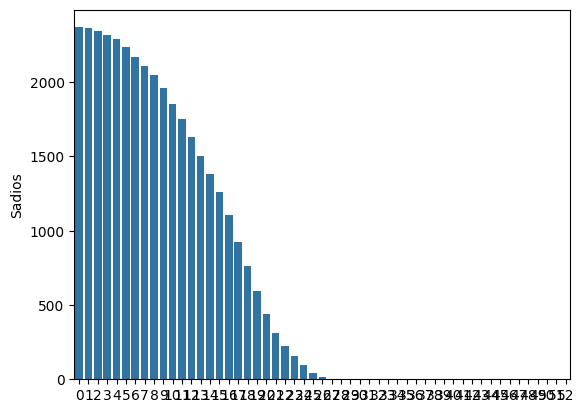

In [1268]:
ax = sns.barplot(data=dados['Sadios'])

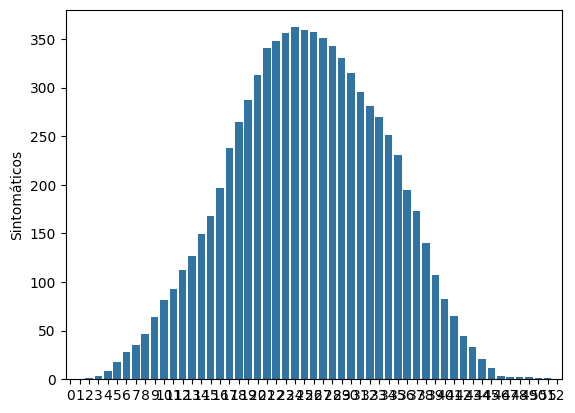

In [1269]:
ax = sns.barplot(data=dados['Sintomáticos'])
#ax.bar_label(ax.containers[0], fontsize=3)


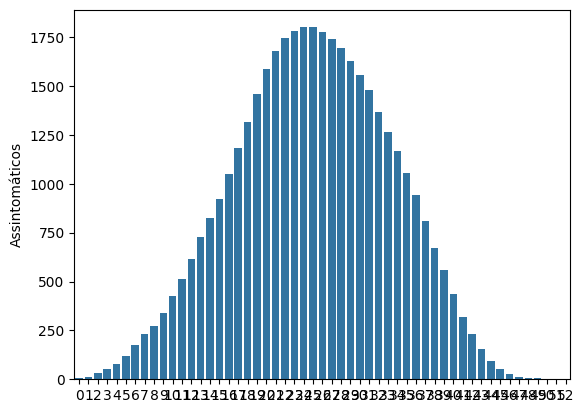

In [1270]:
ax = sns.barplot(data=dados['Assintomáticos'])

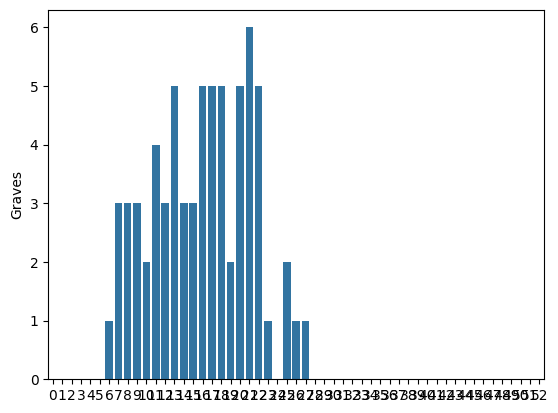

In [1271]:
ax = sns.barplot(data=dados['Graves'])

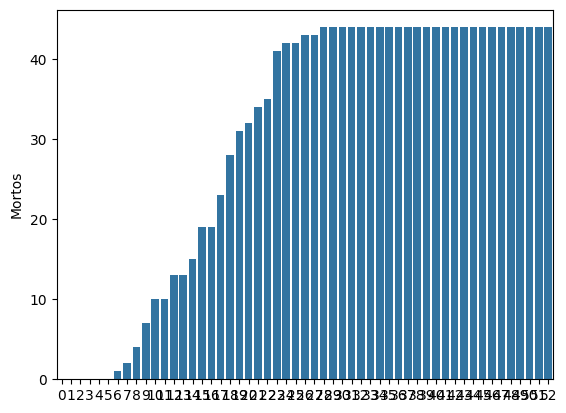

In [1272]:
ax = sns.barplot(data=dados['Mortos'])

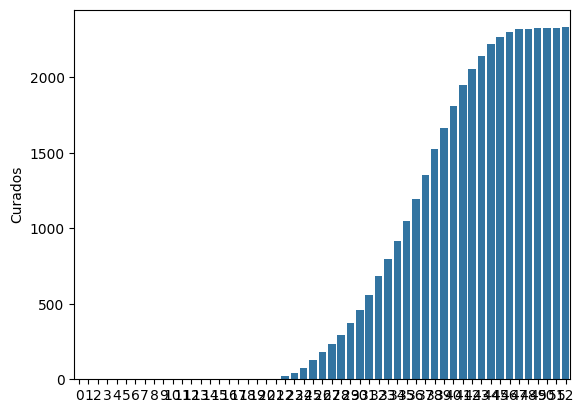

In [1273]:
ax = sns.barplot(data=dados['Curados'])

In [1274]:
sad_int = sad.astype(int)
sint_int = sint.astype(int)
assint_int = assint.astype(int)
graves_int = graves.astype(int)
mortos_int = mortos.astype(int)
curados_int = curados.astype(int)

In [1275]:
sad_int.describe()

count      53.000000
mean      684.150943
std       909.352927
min         0.000000
25%         0.000000
50%        17.000000
75%      1503.000000
max      2370.000000
Name: Sadios, dtype: float64

In [1276]:
sint_int.describe()

count     53.000000
mean     149.245283
std      134.318351
min        0.000000
25%       18.000000
50%      112.000000
75%      281.000000
max      362.000000
Name: Sintomáticos, dtype: float64

In [1277]:
assint_int.describe()

count      53.000000
mean      750.867925
std       660.147100
min         0.000000
25%        91.000000
50%       617.000000
75%      1368.000000
max      1800.000000
Name: Assintomáticos, dtype: float64

In [1278]:
graves_int.describe()

count    53.000000
mean      1.283019
std       1.884934
min       0.000000
25%       0.000000
50%       0.000000
75%       3.000000
max       6.000000
Name: Graves, dtype: float64

In [1279]:
mortos_int.describe()

count    53.000000
mean     30.320755
std      17.439757
min       0.000000
25%      13.000000
50%      43.000000
75%      44.000000
max      44.000000
Name: Mortos, dtype: float64

In [1280]:
curados_int.describe()

count      53.000000
mean      759.132075
std       934.189757
min         0.000000
25%         0.000000
50%       181.000000
75%      1667.000000
max      2331.000000
Name: Curados, dtype: float64

In [1281]:
infect = dados['numero_infectados']

In [1282]:
infect_int = infect.astype(int)

In [1283]:
infect_int.describe()

count      53.000000
mean      901.396226
std       794.914445
min         0.000000
25%       112.000000
50%       732.000000
75%      1649.000000
max      2162.000000
Name: numero_infectados, dtype: float64

In [1284]:
infect_int

0        5
1       13
2       31
3       55
4       87
5      138
6      205
7      267
8      325
9      407
10     509
11     610
12     732
13     859
14     977
15    1095
16    1251
17    1427
18    1586
19    1750
20    1903
21    2027
22    2099
23    2137
24    2162
25    2160
26    2134
27    2094
28    2039
29    1958
30    1873
31    1776
32    1649
33    1536
34    1417
35    1285
36    1137
37     981
38     809
39     664
40     518
41     385
42     274
43     190
44     112
45      63
46      30
47      12
48      10
49       6
50       3
51       2
52       0
Name: numero_infectados, dtype: int64

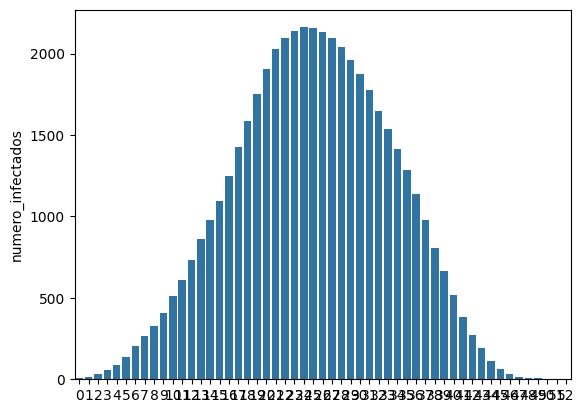

In [1285]:
ax = sns.barplot(data=dados['numero_infectados'])

# **Teste de normalidade**

In [1286]:
def verificar_normalidade(coluna):
    stat, p = stats.shapiro(dados[coluna])
    alpha = 0.05
    if p > alpha:
        print(f'{coluna}: Distribuição Normal (p={p})')
    else:
        print(f'{coluna}: Distribuição NÃO Normal (p={p})')

In [1287]:
for coluna in ['Sadios','Assintomáticos', 'Sintomáticos', 'Graves', 'Mortos', 'Curados']:
    verificar_normalidade(coluna)

Sadios: Distribuição NÃO Normal (p=1.2935425175442106e-08)
Assintomáticos: Distribuição NÃO Normal (p=4.104456093045883e-05)
Sintomáticos: Distribuição NÃO Normal (p=2.1426441890071146e-05)
Graves: Distribuição NÃO Normal (p=4.829382227455881e-09)
Mortos: Distribuição NÃO Normal (p=2.1697461605185708e-08)
Curados: Distribuição NÃO Normal (p=3.655717506489964e-08)


In [1288]:
    verificar_normalidade('numero_infectados')


numero_infectados: Distribuição NÃO Normal (p=3.717487197718583e-05)


In [1289]:
def verificar_normalidade_h(coluna):
    plt.figure(figsize=(6, 3))
    sns.histplot(dados[coluna], kde=True, bins=10)
    plt.title(f'{coluna} - Histograma')
    plt.xlabel('Número')
    plt.ylabel('Frequência')
    plt.show()

    # Teste de Shapiro-Wilk para normalidade
    stat, p = stats.shapiro(dados[coluna])
    print(f'Statistic: {stat}, p-value: {p}')

    # Interpretar o resultado do teste de Shapiro-Wilk
    alpha = 0.05
    if p > alpha:
        print(f'{coluna}: Distribuição Normal (p={p}) \n')
    else:
        print(f'{coluna}: Distribuição NÃO Normal (p={p}) \n')

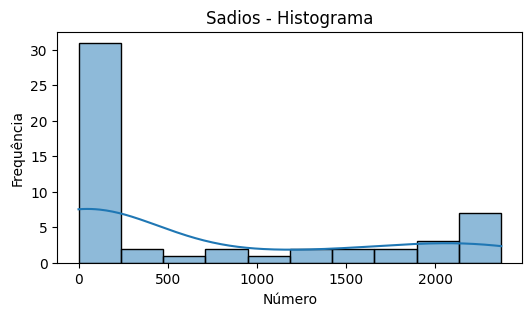

Statistic: 0.7261505722999573, p-value: 1.2935425175442106e-08
Sadios: Distribuição NÃO Normal (p=1.2935425175442106e-08) 



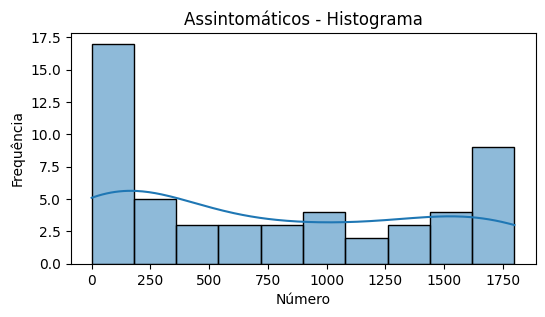

Statistic: 0.8720929026603699, p-value: 4.104456093045883e-05
Assintomáticos: Distribuição NÃO Normal (p=4.104456093045883e-05) 



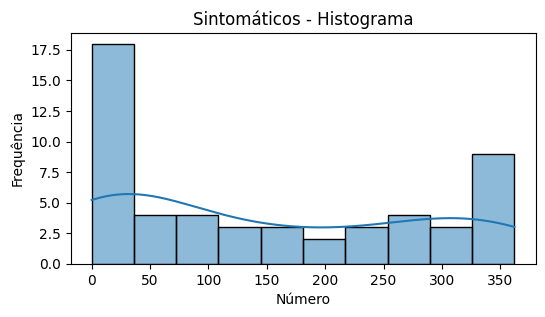

Statistic: 0.8625927567481995, p-value: 2.1426441890071146e-05
Sintomáticos: Distribuição NÃO Normal (p=2.1426441890071146e-05) 



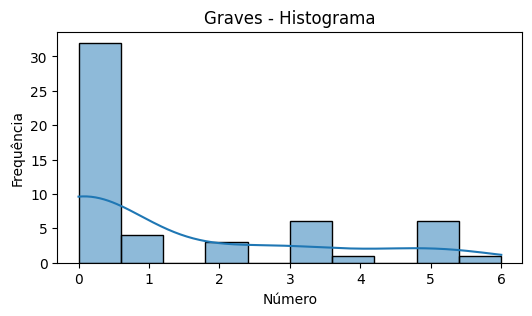

Statistic: 0.7036039233207703, p-value: 4.829382227455881e-09
Graves: Distribuição NÃO Normal (p=4.829382227455881e-09) 



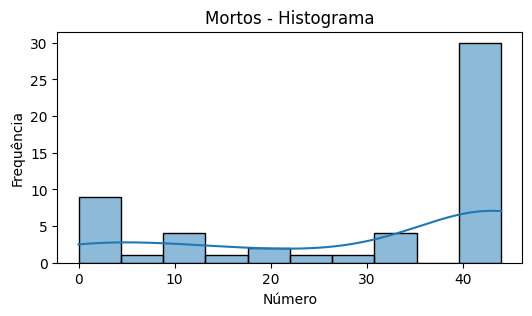

Statistic: 0.7375344038009644, p-value: 2.1697461605185708e-08
Mortos: Distribuição NÃO Normal (p=2.1697461605185708e-08) 



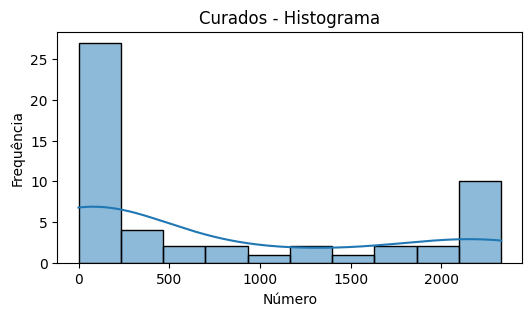

Statistic: 0.7487086057662964, p-value: 3.655717506489964e-08
Curados: Distribuição NÃO Normal (p=3.655717506489964e-08) 



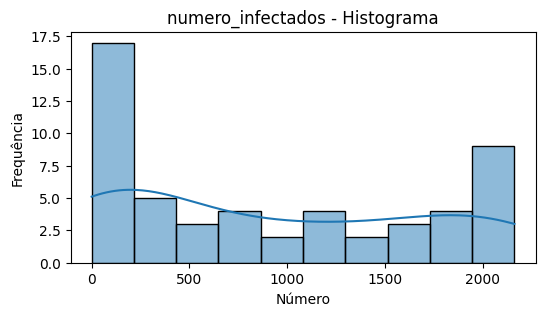

Statistic: 0.870668351650238, p-value: 3.717487197718583e-05
numero_infectados: Distribuição NÃO Normal (p=3.717487197718583e-05) 



In [1290]:
for colunax in ['Sadios','Assintomáticos', 'Sintomáticos', 'Graves', 'Mortos', 'Curados','numero_infectados']:
    verificar_normalidade_h(colunax)

# **Intervalo de Confiança**

In [1291]:
dados['numero_infectados']

0        5
1       13
2       31
3       55
4       87
5      138
6      205
7      267
8      325
9      407
10     509
11     610
12     732
13     859
14     977
15    1095
16    1251
17    1427
18    1586
19    1750
20    1903
21    2027
22    2099
23    2137
24    2162
25    2160
26    2134
27    2094
28    2039
29    1958
30    1873
31    1776
32    1649
33    1536
34    1417
35    1285
36    1137
37     981
38     809
39     664
40     518
41     385
42     274
43     190
44     112
45      63
46      30
47      12
48      10
49       6
50       3
51       2
52       0
Name: numero_infectados, dtype: object

In [1292]:
infect_20 = infect.iloc[0:20]

In [1293]:
infect_20

0        5
1       13
2       31
3       55
4       87
5      138
6      205
7      267
8      325
9      407
10     509
11     610
12     732
13     859
14     977
15    1095
16    1251
17    1427
18    1586
19    1750
Name: numero_infectados, dtype: object

In [1294]:
import numpy as np
import scipy.stats as stats

amostra = infect_20  # Amostra
media = np.mean(amostra)  # Média da amostra
desvio_padrao = np.std(amostra)  # Desvio padrão da amostra
graus_liberdade = len(amostra) - 1  # Graus de liberdade da distribuição t

intervalo_confianca = stats.t.interval(0.95, graus_liberdade, loc=media, scale=desvio_padrao / np.sqrt(len(amostra)))

In [1295]:
intervalo_confianca

(358.9817745577794, 873.9182254422208)

In [1296]:
from scipy.stats import shapiro, norm

# **Teste da hipótese**

Teste de hipótese com 95% de significância com H0=µ0≥ 3/10000 para os
infectados sintomáticos em qualquer tempo? (3/10000 era o número de leitos de UTI
no Brasil por 10000 habitantes em março de 2020).

In [1297]:

from statsmodels.stats.weightstats import ztest
import scipy.stats as stats
import warnings
from statsmodels.stats.weightstats import ttest_ind
warnings.filterwarnings('ignore')

In [1298]:
def ttest_uni(amostra, popmean, alternative):
    n= len(amostra)
    tobs = (np.mean(amostra)-popmean)/np.sqrt(np.var(amostra, ddof=1)/n)
    if(alternative == "smaller"):
        pvalor = stats.t.cdf(tobs,n-1)
    if(alternative == "larger"):
        pvalor = 1 - stats.t.cdf(tobs,n-1)

    return print('(%.16f,%.16f)' % (tobs,pvalor)),pvalue

In [1299]:
sint_part = sint_int.iloc[0:20]

In [1300]:
sint_part

0       0
1       0
2       1
3       3
4       9
5      18
6      28
7      35
8      47
9      64
10     82
11     93
12    112
13    127
14    149
15    168
16    197
17    238
18    265
19    287
Name: Sintomáticos, dtype: int64

In [1301]:
stats.ttest_1samp(sint_part,popmean = 0.0003)

TtestResult(statistic=4.595445408485302, pvalue=0.00019748906520610537, df=19)

In [1302]:
estatistics,pvalue = stats.ttest_1samp(sint_part,popmean = 0.0003)

In [1303]:
estatistics

4.595445408485302

In [1304]:
pvalue

0.00019748906520610537

pvalue inferior ao 0,0003 , quantidade de leitos na epoca, h0 rejeitada

pvalue

# **Chi-Square. verificar independência entre assintomáticos e sintomáticos**

In [1305]:
from scipy.stats import chi2_contingency
# Defining a function to perform the Chi-Square Test and interpret results
def perform_chi_square_test(data, col1, col2):
    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant

In [1306]:
perform_chi_square_test(dados, 'Assintomáticos', 'Sintomáticos')

(2385.0, 0.2535521428262648, False)

In [1307]:
contingencia = pd.crosstab(index=dados['Assintomáticos'], columns=dados['Sintomáticos'])
print("\nTabela de Contingência Assintomáticos x Sintomáticos:\n", contingencia)

# Realizar o teste qui-quadrado
chi2, p, dof, expected = stats.chi2_contingency(contingencia)

print(f"\nChi-Square:")
print(f"Chi2: {chi2}")
print(f"p-valor: {p}")
print(f"Graus de Liberdade: {dof}")
#print(f"Frequências Esperadas:\n{expected}")

# Verificar a independência
alpha = 0.05
if p < alpha:
    print("\nRejeitamos a hipótese nula. Existe uma associação entre Assintomáticos e Sintomáticos.")
else:
    print("\nNão rejeitamos a hipótese nula. NÃO existe uma associação significativa entre Assintomáticos e Sintomáticos.")


Tabela de Contingência Assintomáticos x Sintomáticos:
 Sintomáticos    0    1    2    3    9    12   18   21   28   33   ...  315  \
Assintomáticos                                                    ...        
0                 1    0    0    0    0    0    0    0    0    0  ...    0   
1                 0    1    0    0    0    0    0    0    0    0  ...    0   
2                 0    1    0    0    0    0    0    0    0    0  ...    0   
4                 0    0    1    0    0    0    0    0    0    0  ...    0   
5                 1    0    0    0    0    0    0    0    0    0  ...    0   
8                 0    0    1    0    0    0    0    0    0    0  ...    0   
10                0    0    1    0    0    0    0    0    0    0  ...    0   
13                1    0    0    0    0    0    0    0    0    0  ...    0   
27                0    0    0    1    0    0    0    0    0    0  ...    0   
30                0    1    0    0    0    0    0    0    0    0  ...    0   
51      

# **10. Se esta doença atacasse uma população de 216,422,446, qual seria o prognostico de mortes em 1 ano?**

In [1308]:
mortes_total = dados['Mortos'].max()
mortes_total

44

In [1309]:
popul = n * n
popul

2500

In [1310]:
taxa_mortalidade = mortes_total/popul
taxa_mortalidade

0.0176

In [1311]:
populacao_teste = 216422446

In [1312]:
prognostico_mortos = populacao_teste * taxa_mortalidade
prognostico_mortos

3809035.0496

csv-final

In [1313]:
dados

,Passo,Assintomáticos,Sintomáticos,Graves,Mortos,Curados,Sadios,Resistentes,numero_infectados
0,1,5,0,0,0,0,2370.0,125.0,5
1,2,13,0,0,0,0,2362.0,125.0,13
2,3,30,1,0,0,0,2344.0,125.0,31
3,4,52,3,0,0,0,2320.0,125.0,55
4,5,78,9,0,0,0,2288.0,125.0,87
5,6,120,18,0,0,0,2237.0,125.0,138
6,7,176,28,1,1,0,2169.0,125.0,205
7,8,229,35,3,2,0,2106.0,125.0,267
8,9,275,47,3,4,0,2046.0,125.0,325
9,10,340,64,3,7,0,1961.0,125.0,407
